In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### Helper function to calculate angle

In [2]:
def calculate_angle(a, b, c):
    """
    Calculate the angle between three points.
    a, b, c should be arrays/lists with [x, y] coordinates.
    b is the vertex point.
    Returns the angle in degrees.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    # Calculate the angle in radians and then convert to degrees
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    # Ensure angle is within [0, 180]
    if angle > 180.0:
        angle = 360 - angle
        
    return angle


###  Initialize MediaPose Model to set detection

In [3]:
# Initialize MediaPipe Pose solution and drawing utilities
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_draw = mp.solutions.drawing_utils


### Process the prerecorded video and count pushups

In [4]:
from IPython.display import clear_output, display, Image
import time

# Path of the video to be processed
video_path = "pushup_video.mp4"

# Open the video file using OpenCV
cap = cv2.VideoCapture(video_path)

# Retrieve the video FPS (frames per second) to control playback speed
fps = cap.get(cv2.CAP_PROP_FPS)

# Initialize pushup counting variables
pushup_count = 0
stage = "up"  # Start assuming the person is in the "up" (extended) position

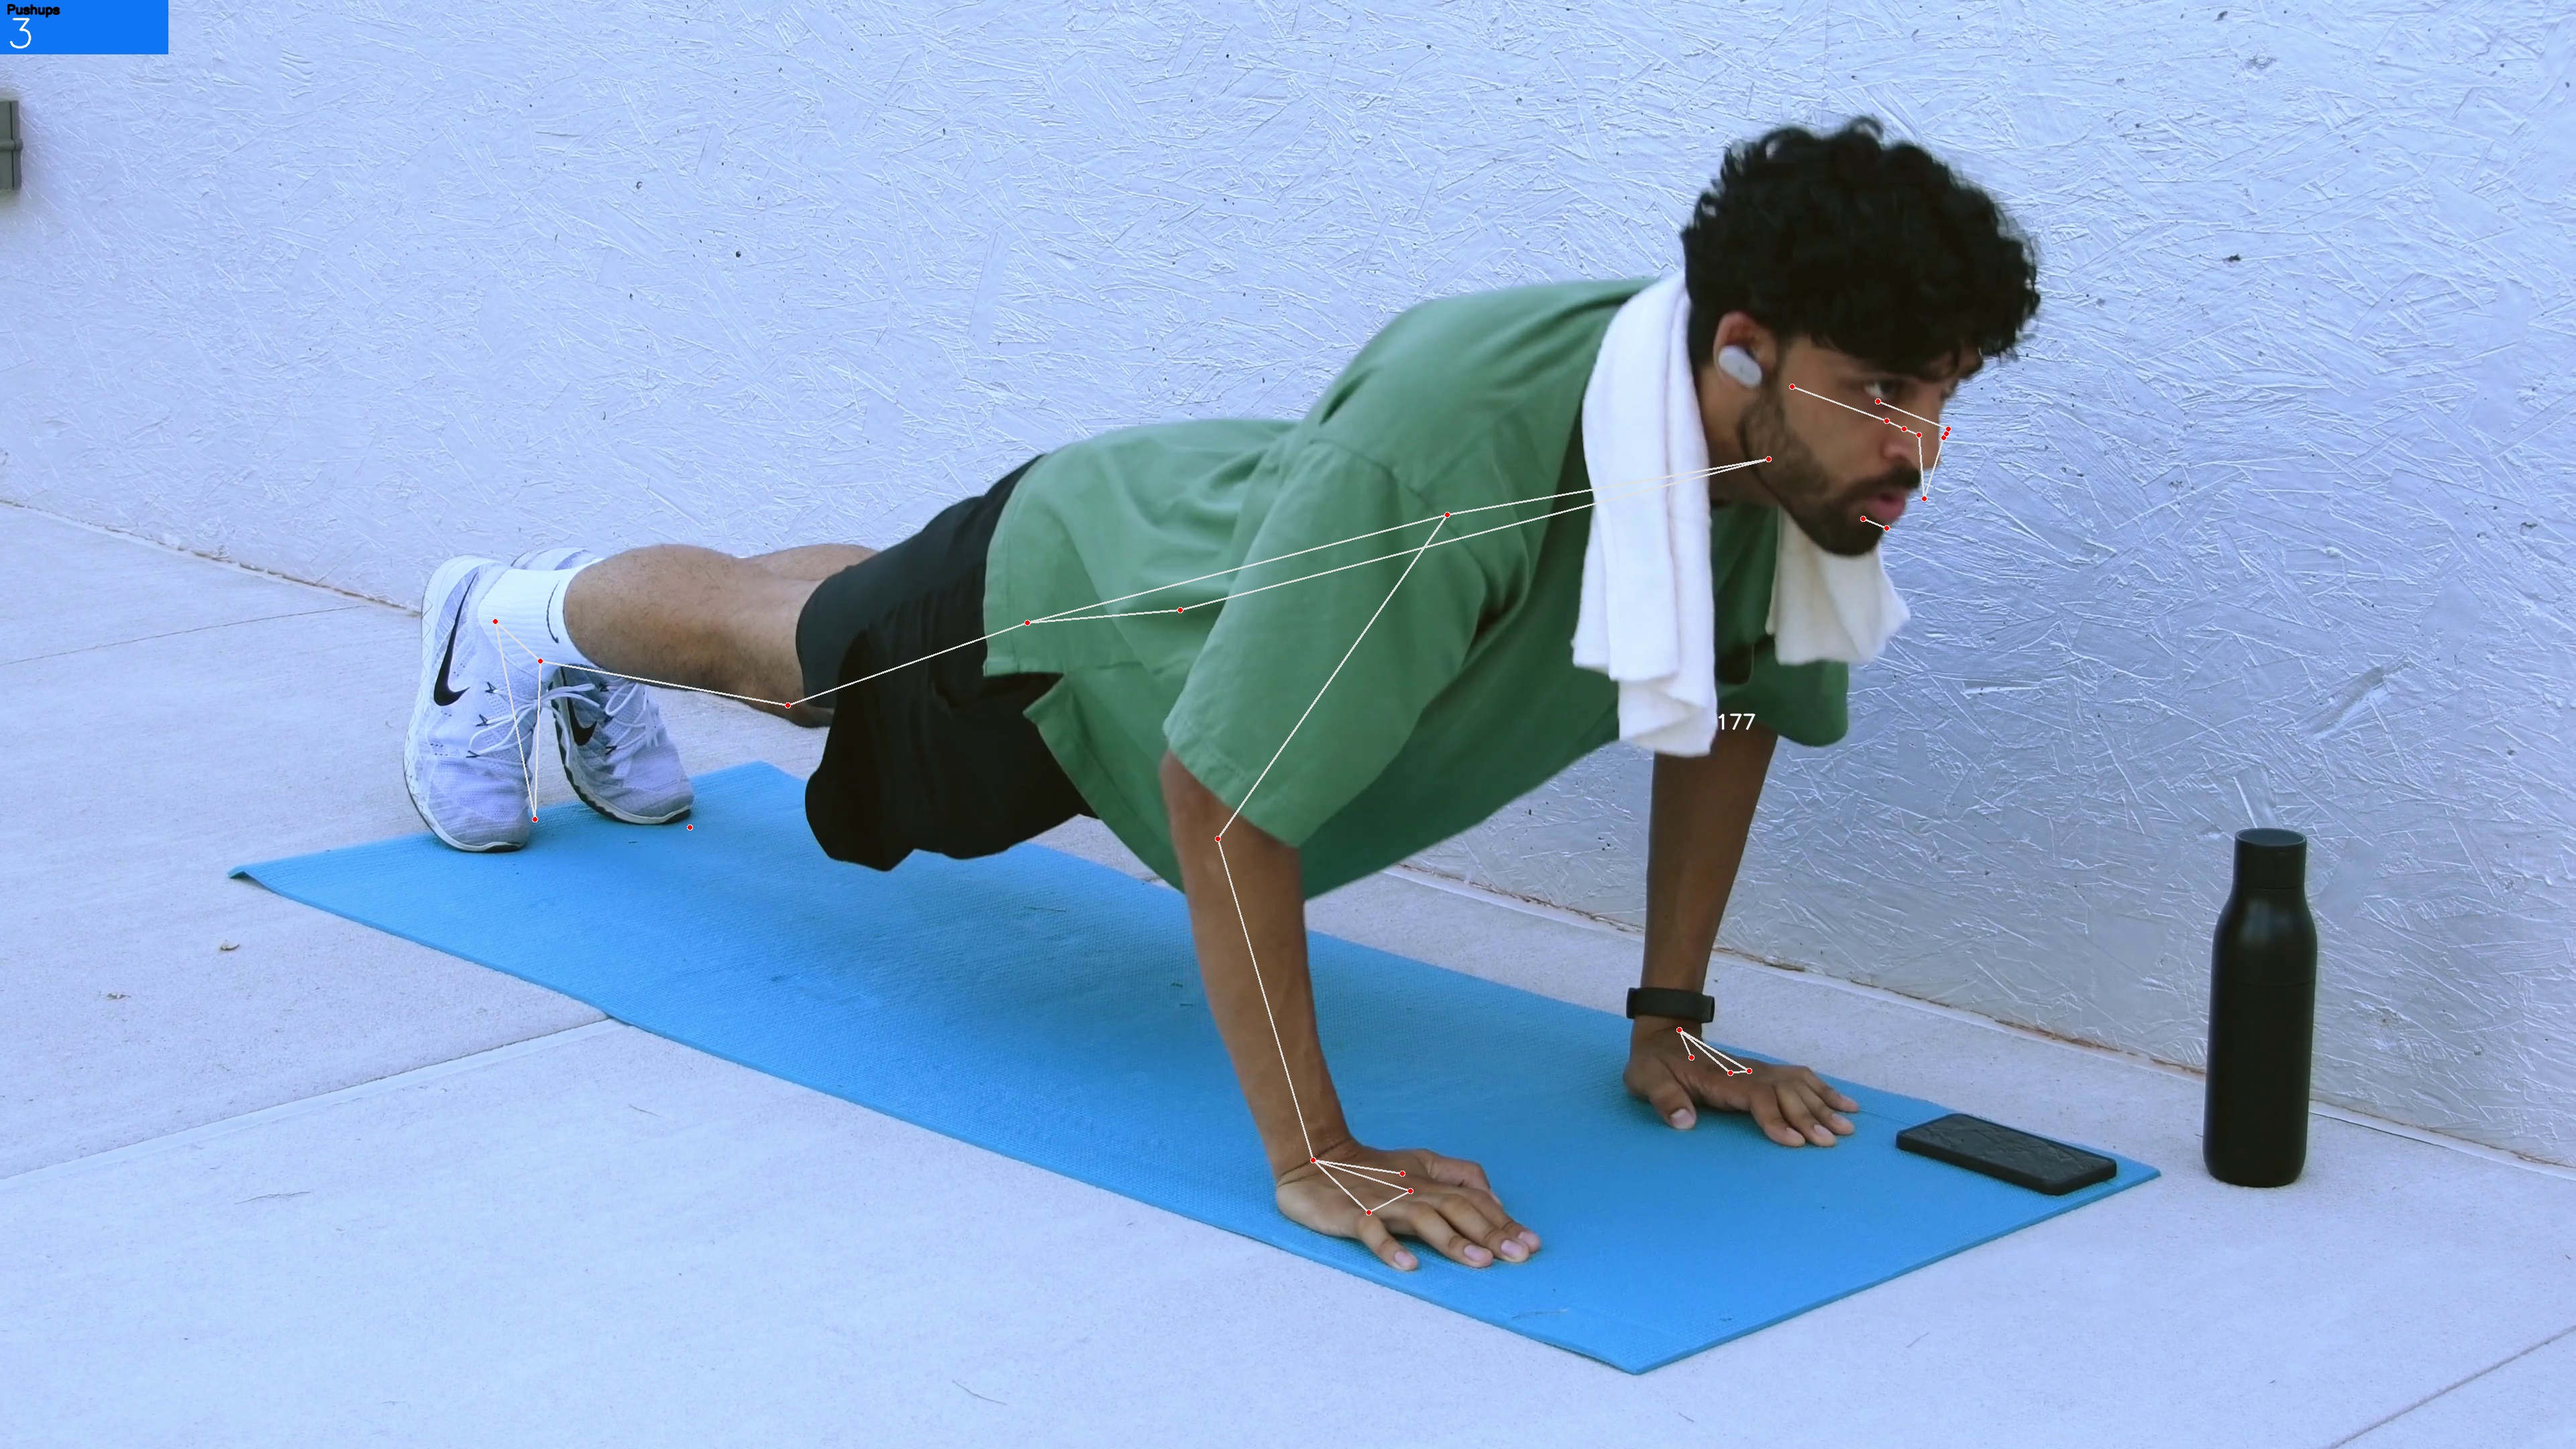

Pushup Count: 3


KeyboardInterrupt: 

In [5]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit the loop when the video ends

    # ----- Step 1: Preprocess the Frame -----
    # Convert the frame from BGR to RGB (MediaPipe requires RGB)
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False  # Optimize performance
    results = pose.process(image)
    image.flags.writeable = True
    # Convert the frame back to BGR for display with OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # ----- Step 2: Extract Landmarks and Compute the Elbow Angle -----
    try:
        landmarks = results.pose_landmarks.landmark
        
        # Extract coordinates for left shoulder, elbow, and wrist.
        shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                    landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
        wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
        
        # Calculate the elbow angle using the helper function.
        angle = calculate_angle(shoulder, elbow, wrist)
        
        # Convert normalized coordinates to pixel coordinates (for annotation)
        h, w, _ = image.shape
        elbow_pixel = tuple(np.multiply(elbow, [w, h]).astype(int))
        
        # Draw the calculated angle near the elbow
        cv2.putText(image, str(int(angle)),
                    elbow_pixel,
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # ----- Pushup Counting Logic -----
        # If the elbow angle is less than 120, we assume the person is in the "down" position.
        if angle < 120:
            # Only update stage if not already in "down" (to avoid repeated setting)
            if stage != "down":
                stage = "down"
        # If the angle is greater than 175 and the previous stage was "down",
        # this means the person has come back up from a pushup.
        elif angle > 175:
            if stage == "down":
                pushup_count += 1
                stage = "up"  # Reset stage to "up"
                
                
    except Exception as e:
        # If no landmarks are detected, skip this frame.
        pass

    # ----- Step 3: Annotate the Frame -----
    # Overlay a rectangle and display the current pushup count.
    cv2.rectangle(image, (0, 0), (250, 80), (245, 117, 16), -1)
    cv2.putText(image, 'Pushups', (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(image, str(pushup_count),
                (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
    
    # Draw the pose landmarks for visual feedback.
    if results.pose_landmarks:
        mp_draw.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # ----- Step 4: Display the Frame in Real Time -----
    # Encode the frame as a JPEG image.
    ret2, buffer = cv2.imencode('.jpg', image)
    if not ret2:
        continue  # Skip frame if encoding fails
    
    # Clear the previous output and display the updated frame.
    clear_output(wait=True)
    display(Image(data=buffer.tobytes()))
    
    # Print the current pushup count beneath the frame.
    print("Pushup Count:", pushup_count)
    
    # Pause briefly to match the video's FPS for smooth playback.
    time.sleep(1 / fps)

# Release the video capture resource when done.
cap.release()
print("Video processing complete!")
